In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import os


In [3]:
# 1. Load data via memmap
file_path = "data/processed/cae/craters.npy"
file_size = os.path.getsize(file_path)
N_total = file_size // (224 * 224 * 1 * 4)
data = np.memmap(
    file_path,
    dtype=np.float32,
    mode="r",
    shape=(N_total, 1, 224, 224)
)

# 2. Sample what you need
n_samples = 50000
random_indices = np.random.choice(N_total, size=n_samples, replace=False)

# 3. Load to CPU and reshape
print(f"Loading {n_samples} samples...")
X = data[random_indices].reshape(n_samples, -1)

# 4. Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. PCA with randomized solver (fast and memory efficient)
from sklearn.decomposition import PCA
n_comp = 50  # or 0.95 for variance
print(f"Running PCA...")
pca = PCA(n_components=n_comp, svd_solver='randomized')
X_pca = pca.fit_transform(X_scaled)

print(f"PCA complete!")
print(f"Shape: {X_pca.shape}")
print(f"Variance captured: {pca.explained_variance_ratio_.sum():.2%}")

Loading 50000 samples...
Running PCA...
PCA complete!
Shape: (50000, 50)
Variance captured: 96.96%


In [4]:
# 4. Visualize Reconstruction of specific components (Eigen-craters)
def plot_pca_components(pca, original_shape, n_to_show=10):
    """
    Shows the 'Eigen-craters' in rows of 5.
    These are the templates PCA uses to reconstruct your images.
    """
    cols = 5
    rows = math.ceil(n_to_show / cols)
    
    plt.figure(figsize=(15, 3 * rows))
    
    for i in range(min(n_to_show, len(pca.components_))):
        plt.subplot(rows, cols, i + 1)
        
        # Reshape the flat vector back to 224x224
        component_img = pca.components_[i].reshape(original_shape)
        
        # Use 'gray' and center the colorbar around 0
        # Components have positive and negative values
        plt.imshow(component_img, cmap='gray')
        
        plt.title(f"PC {i+1}\nVar: {pca.explained_variance_ratio_[i]:.2%}")
        plt.axis('off')
    
    plt.suptitle("Principal Components: The 'Templates' of your Crater Data", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_reconstruction(X_scaled, X_pca, pca, scaler, original_shape, n_examples=5, random_seed=None):
    """
    Visualizes original vs reconstructed craters and calculates pixel-wise error.
    Randomly selects examples from the dataset.
    
    Parameters:
    -----------
    random_seed : int, optional
        Random seed for reproducibility. If None, examples will be different each time.
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    
    # Randomly select indices
    if random_seed is not None:
        np.random.seed(random_seed)
    n_total = X_scaled.shape[0]
    random_indices = np.random.choice(n_total, size=n_examples, replace=False)
    
    # Inverse transform to get back to original pixel space
    X_reconstructed_scaled = pca.inverse_transform(X_pca)
    X_reconstructed = scaler.inverse_transform(X_reconstructed_scaled)
    X_original = scaler.inverse_transform(X_scaled)

    plt.figure(figsize=(15, 7))
    
    for plot_idx, data_idx in enumerate(random_indices):
        # Calculate MSE for this specific image
        mse_val = mean_squared_error(X_original[data_idx], X_reconstructed[data_idx])
        
        # 1. Original Image (Top Row)
        plt.subplot(2, n_examples, plot_idx + 1)
        plt.imshow(X_original[data_idx].reshape(original_shape), cmap='gray')
        plt.title(f"Original {data_idx}")
        plt.axis('off')

        # 2. Reconstructed Image (Bottom Row)
        plt.subplot(2, n_examples, plot_idx + 1 + n_examples)
        plt.imshow(X_reconstructed[data_idx].reshape(original_shape), cmap='gray')
        # Display variance explained and MSE
        variance_explained = pca.explained_variance_ratio_.sum()
        plt.title(f"{pca.n_components_} comp ({variance_explained:.1%})\nMSE: {mse_val:.4f}")
        plt.axis('off')
        
    plt.suptitle(f"PCA Reconstruction: {pca.n_components_} Components Retained", fontsize=16)
    plt.tight_layout()
    plt.show()


def compare_reconstruction_progressive(X_scaled, X_pca, pca, scaler, original_shape, 
                                       n_examples=5, component_levels=None, random_seed=None):
    """
    Shows how reconstruction quality improves with 1, 2, 5, 10, 20, etc. components.
    Randomly selects examples from the dataset.
    
    Parameters:
    -----------
    component_levels : list of int, optional
        List of component counts to compare (e.g., [1, 2, 5, 10, 20, 50, 100])
        If None, uses [1, 2, 5, 10, 20, 50, 100, 200, pca.n_components_]
    random_seed : int, optional
        Random seed for reproducibility. If None, examples will be different each time.
    """
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Randomly select indices
    if random_seed is not None:
        np.random.seed(random_seed)
    n_total = X_scaled.shape[0]
    random_indices = np.random.choice(n_total, size=n_examples, replace=False)
    
    # Default component levels if not provided
    if component_levels is None:
        max_components = pca.n_components_
        component_levels = [1, 2, 5, 10, 20, 50, 100, 200, max_components]
        # Filter out values greater than max_components and remove duplicates
        component_levels = sorted(set([c for c in component_levels if c <= max_components]))
    
    # Get original images (unstandardized) - only for selected indices
    X_original = scaler.inverse_transform(X_scaled)
    
    # Create figure
    n_rows = len(component_levels) + 1  # +1 for original row
    fig, axes = plt.subplots(n_rows, n_examples, figsize=(3*n_examples, 3*n_rows))
    
    # Ensure axes is 2D
    if n_examples == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot original images in first row
    for plot_idx, data_idx in enumerate(random_indices):
        ax = axes[0, plot_idx]
        ax.imshow(X_original[data_idx].reshape(original_shape), cmap='gray')
        ax.set_title(f"Original {data_idx}", fontsize=10)
        ax.axis('off')
    
    # Plot reconstructions for each component level
    for row_idx, n_comp in enumerate(component_levels, start=1):
        # Reconstruct using only first n_comp components
        X_pca_truncated = X_pca[:, :n_comp]
        components_truncated = pca.components_[:n_comp, :]
        mean = pca.mean_
        
        # Manual reconstruction: X_reconstructed = X_pca @ components + mean
        X_reconstructed_scaled = X_pca_truncated @ components_truncated + mean
        X_reconstructed = scaler.inverse_transform(X_reconstructed_scaled)
        
        # Calculate variance explained by these components
        variance_explained = pca.explained_variance_ratio_[:n_comp].sum()
        
        for plot_idx, data_idx in enumerate(random_indices):
            ax = axes[row_idx, plot_idx]
            
            # Calculate MSE for this image
            mse_val = mean_squared_error(X_original[data_idx], X_reconstructed[data_idx])
            
            # Plot reconstructed image
            ax.imshow(X_reconstructed[data_idx].reshape(original_shape), cmap='gray')
            ax.set_title(f"{n_comp} comp\nVar: {variance_explained:.1%}\nMSE: {mse_val:.4f}", 
                        fontsize=9)
            ax.axis('off')
    
    plt.suptitle(f"PCA Reconstruction Quality vs Number of Components", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics (using only the random examples)
    print(f"\nReconstruction Summary (based on {n_examples} random samples):")
    print(f"{'Components':<12} {'Variance':<12} {'Avg MSE':<12}")
    print("-" * 36)
    
    for n_comp in component_levels:
        X_pca_truncated = X_pca[random_indices, :n_comp]
        components_truncated = pca.components_[:n_comp, :]
        X_reconstructed_scaled = X_pca_truncated @ components_truncated + pca.mean_
        X_reconstructed = scaler.inverse_transform(X_reconstructed_scaled)
        
        X_original_subset = X_original[random_indices]
        avg_mse = np.mean([mean_squared_error(X_original_subset[i], X_reconstructed[i]) 
                           for i in range(n_examples)])
        variance_explained = pca.explained_variance_ratio_[:n_comp].sum()
        
        print(f"{n_comp:<12} {variance_explained:<12.2%} {avg_mse:<12.6f}")

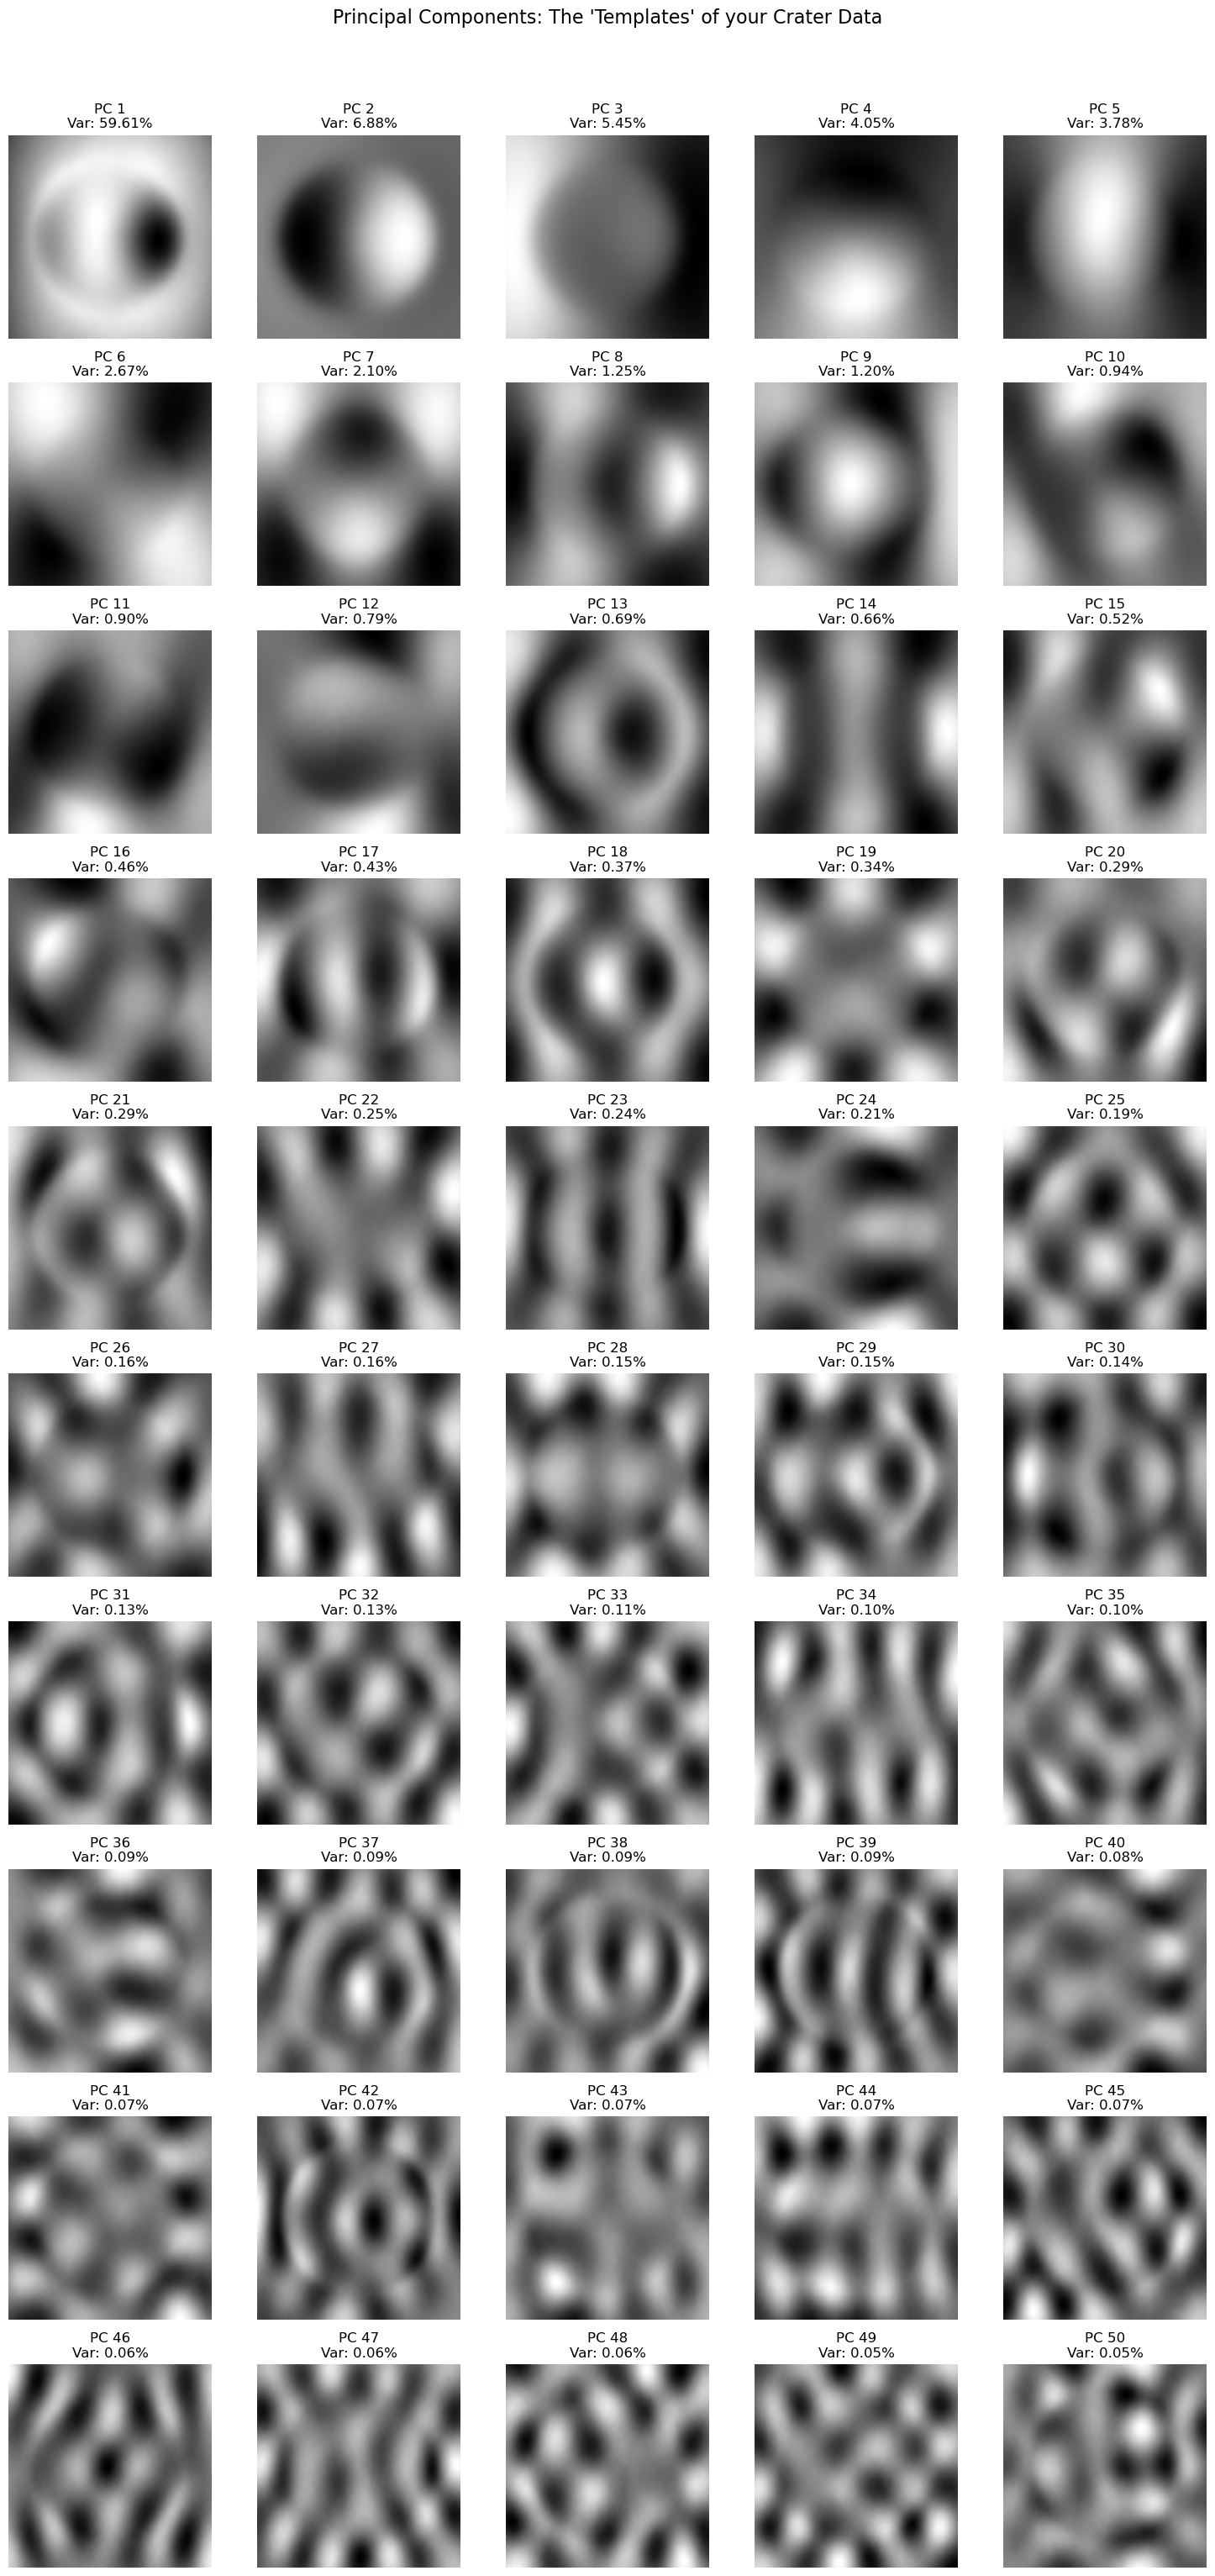

In [5]:
# Define the original image shape
original_shape = (224, 224)
plot_pca_components(pca, original_shape,50)


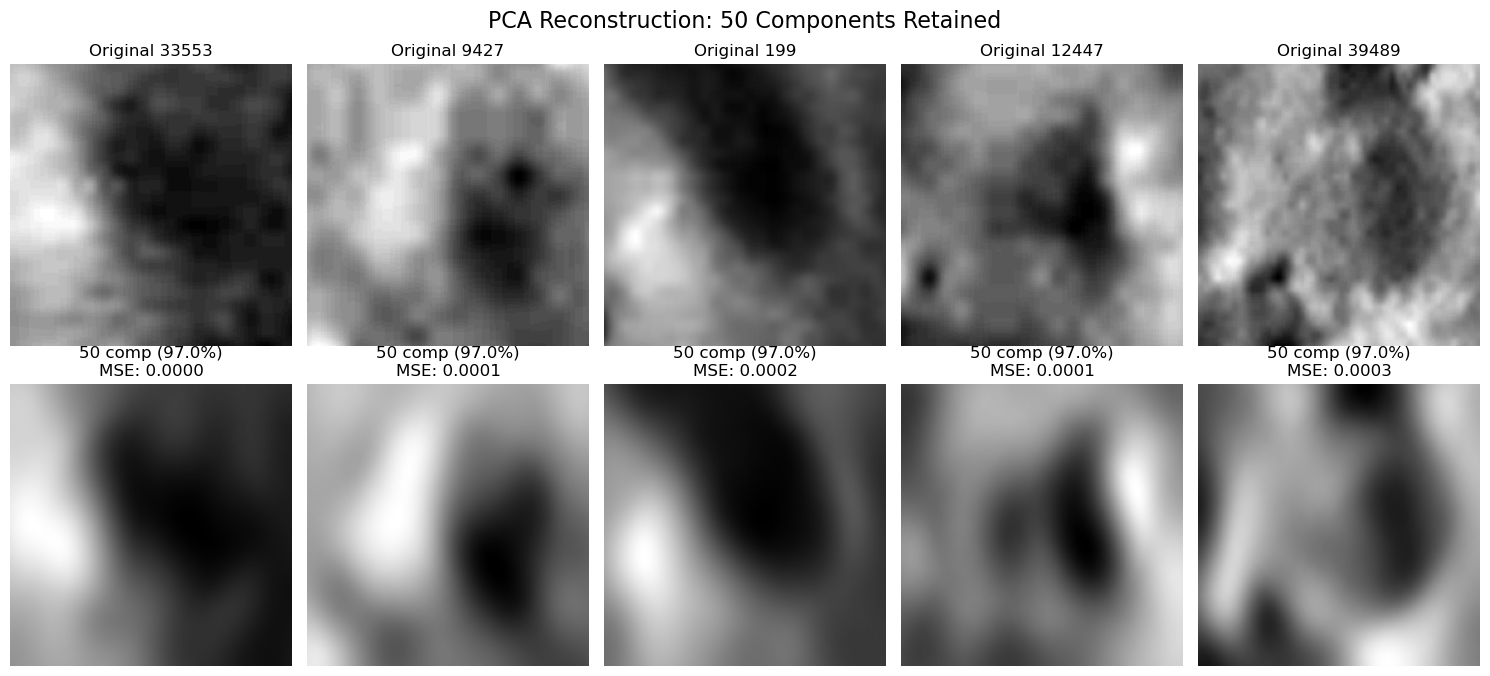

In [6]:
# 2. With random examples but reproducible (same examples each time)
compare_reconstruction(X_scaled, X_pca, pca, scaler, (224, 224), n_examples=5, random_seed=42)


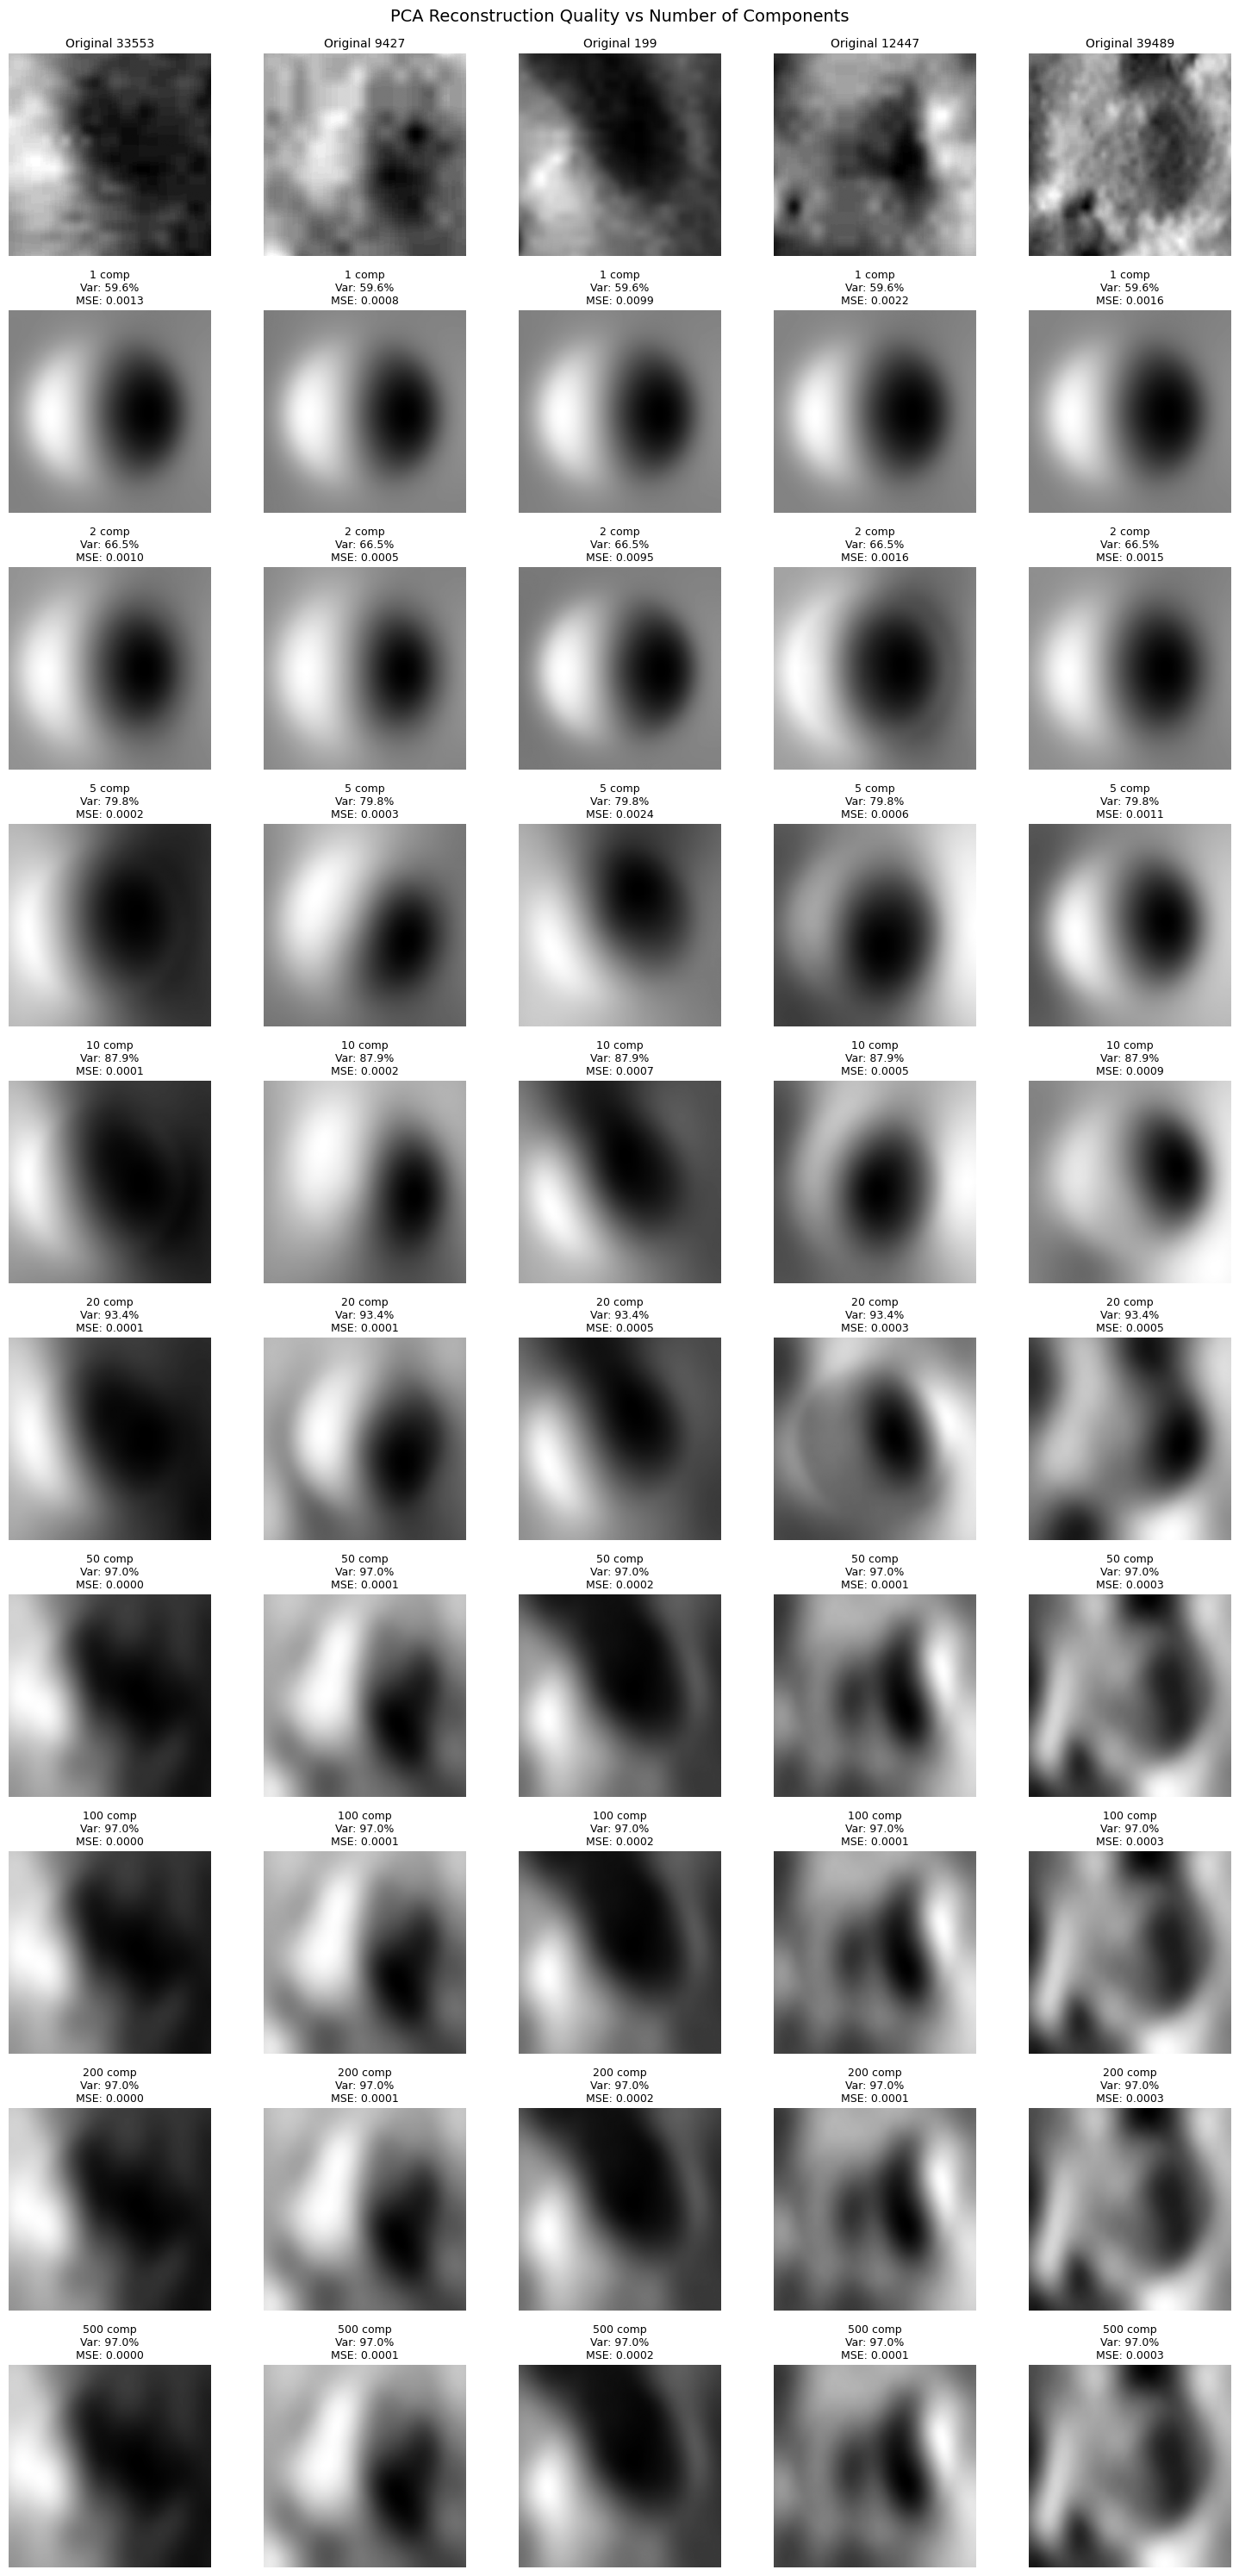


Reconstruction Summary (based on 5 random samples):
Components   Variance     Avg MSE     
------------------------------------
1            59.61%       0.003166    
2            66.49%       0.002831    
5            79.77%       0.000911    
10           87.92%       0.000471    
20           93.37%       0.000275    
50           96.96%       0.000131    
100          96.96%       0.000131    
200          96.96%       0.000131    
500          96.96%       0.000131    


In [7]:
# 3. Progressive reconstruction with random examples
compare_reconstruction_progressive(X_scaled, X_pca, pca, scaler, (224, 224), 
                                   n_examples=5, 
                                   component_levels=[1, 2, 5, 10, 20, 50, 100, 200, 500],
                                   random_seed=42)

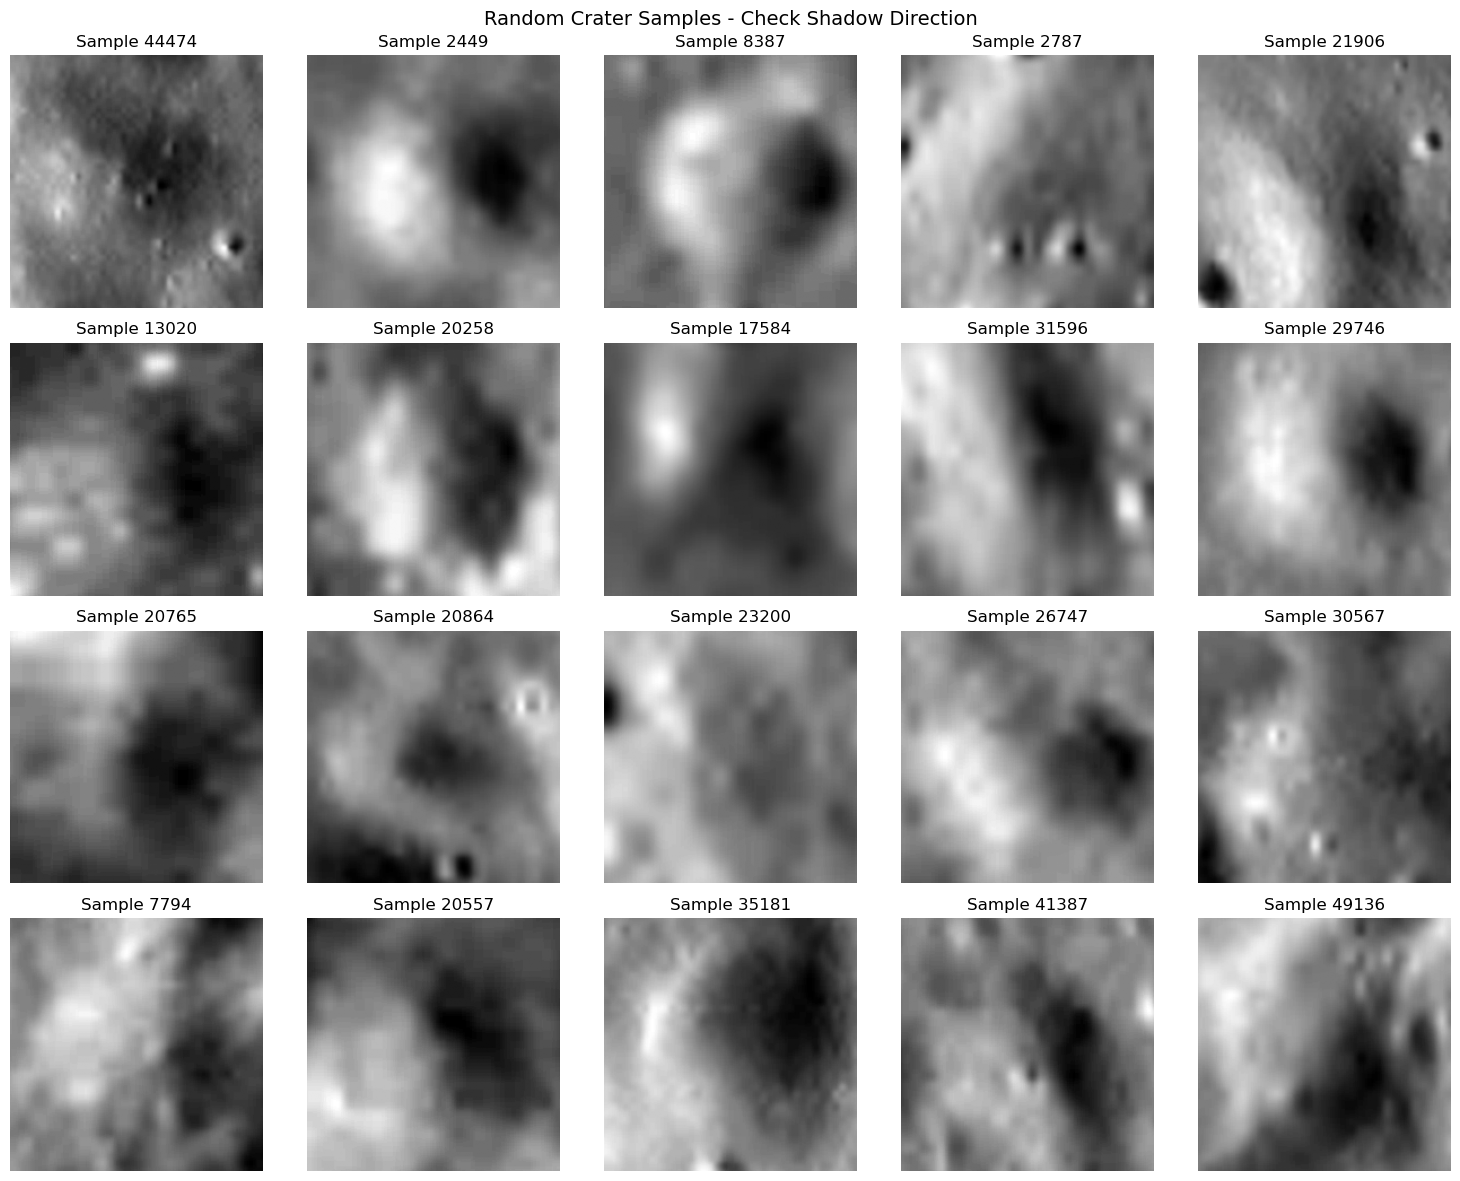

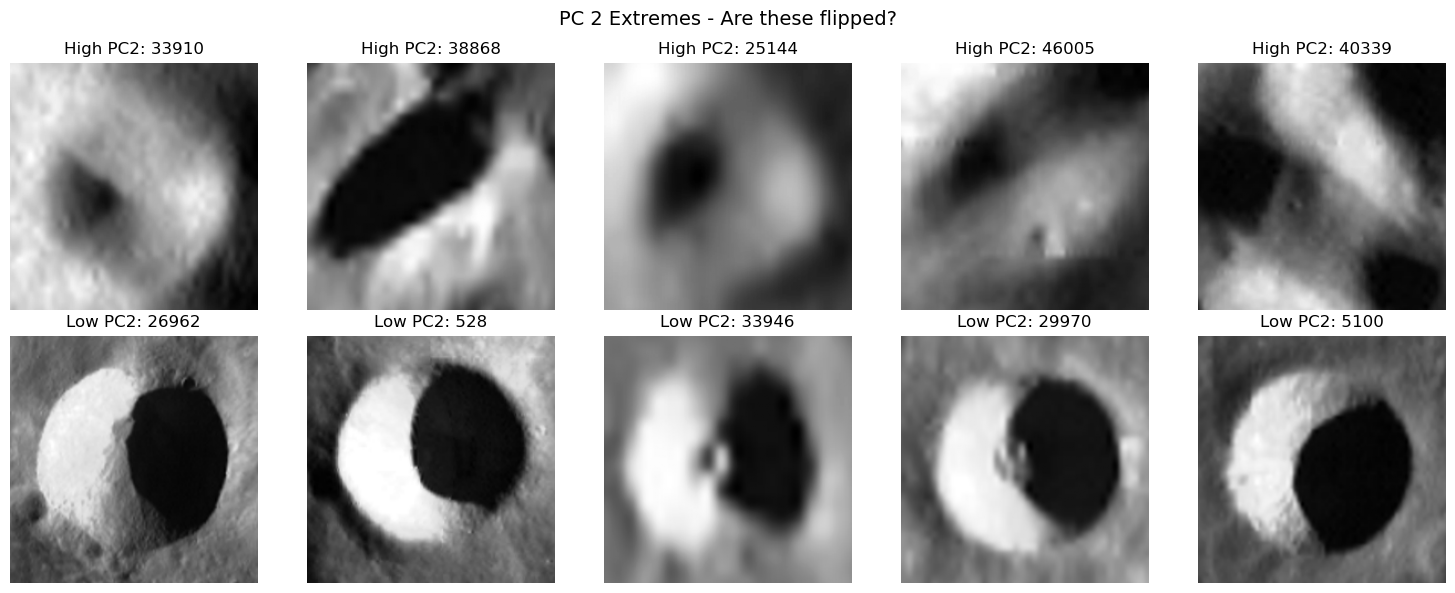

In [8]:
# Check if you have any left-right flipped craters in your data
import numpy as np
import matplotlib.pyplot as plt

# Get original (unstandardized) images
X_original = scaler.inverse_transform(X_scaled)

# Look at some random samples
n_check = 20
random_indices = np.random.choice(X_original.shape[0], size=n_check, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = X_original[idx].reshape(224, 224)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Sample {idx}")
    axes[i].axis('off')

plt.suptitle("Random Crater Samples - Check Shadow Direction", fontsize=14)
plt.tight_layout()
plt.show()

# Also check: Look at extreme examples along PC 2
# Images with high positive PC 2 scores vs high negative PC 2 scores
pc2_scores = X_pca[:, 1]  # PC 2 is index 1

high_pc2_idx = np.argsort(pc2_scores)[-5:]  # Top 5
low_pc2_idx = np.argsort(pc2_scores)[:5]    # Bottom 5

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(high_pc2_idx):
    axes[0, i].imshow(X_original[idx].reshape(224, 224), cmap='gray')
    axes[0, i].set_title(f"High PC2: {idx}")
    axes[0, i].axis('off')

for i, idx in enumerate(low_pc2_idx):
    axes[1, i].imshow(X_original[idx].reshape(224, 224), cmap='gray')
    axes[1, i].set_title(f"Low PC2: {idx}")
    axes[1, i].axis('off')

plt.suptitle("PC 2 Extremes - Are these flipped?", fontsize=14)
plt.tight_layout()
plt.show()